In [118]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: __________Ishaan Malra____________
- PRN : _________250840128017_____________
- Date: ___________18/11/2025___________

# Deep Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [119]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from jupyter_server.terminal import initialize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
# from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

In [120]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()




In [121]:



def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [122]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', '..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'

altName = 'A04_fashion_vanila'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [123]:
###-----------------
### Hyper Parameters
###-----------------

EPOCHS = 100 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 16 # mini batch size (number of rows)
TRAIN_SIZE=int(18*BATCH_SIZE)
WEIGHT_DECAY=0.001 #AdamW
PATIENCE=20         #Early Stopping
LR_FACTOR=0.1       #Reduction on LR Factor
LR_PATIENCE=5       #How long should I wait
MIN_LR=1e-6         #Min


## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [124]:
train_filename = os.path.join('fashion-mnist_train.csv')
test_filename = os.path.join('fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [125]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [126]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
# mm=MinMaxScaler().set_output(transform='pandas')
# train_df=mm.fit_transform(train_df)
# test_df=mm.transform(test_df)

In [128]:
X_train = train_df.drop('label', axis=1).to_numpy()
y_train = train_df['label'].to_numpy()
X_test = test_df.drop('label', axis=1).to_numpy()
y_test = test_df['label'].to_numpy()

In [129]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [130]:
# mm=MinMaxScaler()
# X_train=mm.fit_transform(X_train)
# X_test=mm.transform(X_test)
# y_train=mm.fit_transform(y_train)
# # y_test=mm.transform(y_test)

In [131]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [132]:
train_ds=train_ds.shuffle(buffer_size=train_df.shape[0]).batch(BATCH_SIZE)
test_ds=test_ds.shuffle(buffer_size=test_df.shape[0]).batch(BATCH_SIZE)

In [133]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

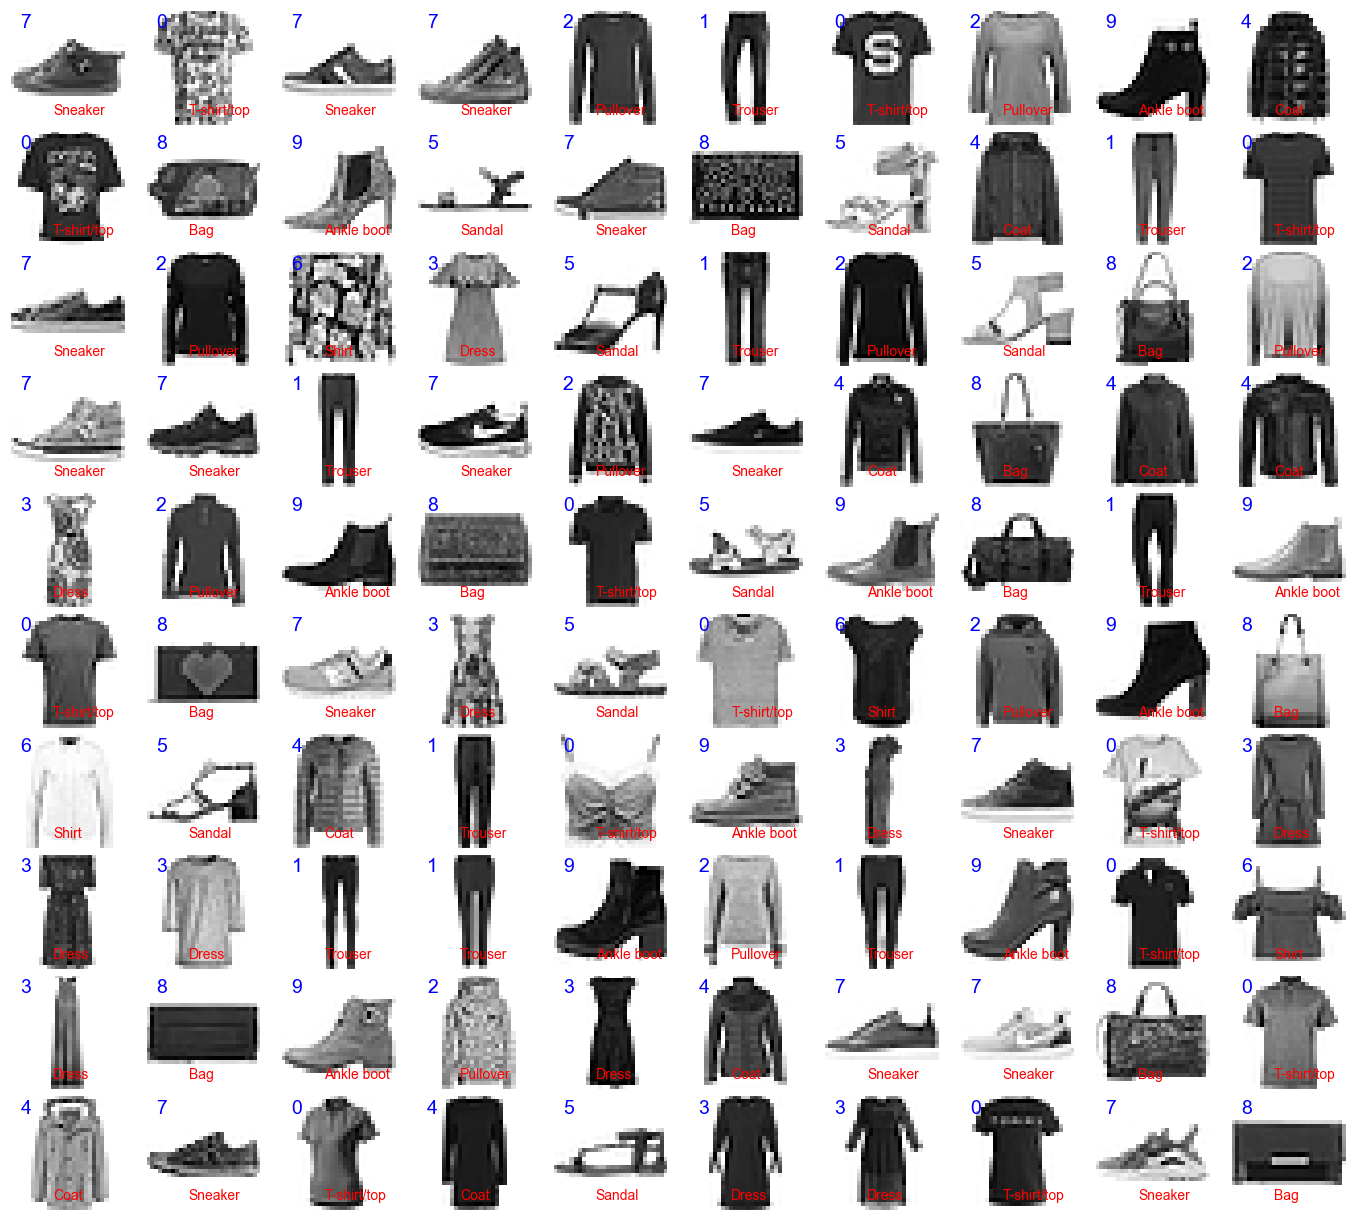

In [134]:
 #Sample data plot
plot_df=train_df.sample(n=100)
fig=plt.figure(figsize = (15,12))
fig.subplots_adjust(left=0,bottom=0,top=1,hspace=0.05,wspace=0.05)
i=0
for _,row in plot_df.iterrows():
    i=i+1
    image=row.values[1:].reshape(28,28)
    ax=fig.add_subplot(10,10,(i),xticks=[],yticks=[])
    ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest')
    ax.text(2,4,str(row.iloc[0]),color='b',fontsize=14)
    ax.text(10,25,class_names[row.iloc[0]],color='r',fontsize=10)
plt.show()

### with dropout

In [135]:

initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
regularizer = tf.keras.regularizers.L2(0.05)

dor1 = 0.2
dor2 = 0.3


model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(784,)),

        tf.keras.layers.Dense(196,kernel_initializer=initializer),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(dor1),

        tf.keras.layers.Dense(49,kernel_initializer=initializer),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(dor2),
        tf.keras.layers.Dense(10,kernel_initializer=initializer),



    ]
)

In [136]:
# model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])


In [137]:
# history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)


In [138]:
# loss_df = pd.DataFrame(history.history)
# loss_df.plot(y=["loss", "val_loss"])
# plt.show()

In [139]:
# fn_plot_tf_hist(loss_df)

In [140]:
# prob_model = tf.keras.Sequential([
#     model,
#     tf.keras.layers.Softmax()
# ])

In [141]:


# y_pred = prob_model(X_test).numpy()
#
# print(f"Accuracy: {accuracy_score(y_test, y_pred.argmax(axis=1)):.4f}")
# print(classification_report(y_test, y_pred.argmax(axis=1)))

## with Batch Normilization

In [142]:

initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
ptimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
oregularizer = tf.keras.regularizers.L2(0.05)

dor1 = 0.2
dor2 = 0.2


model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(784,)),

        tf.keras.layers.Dense(196,kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(dor1),

        tf.keras.layers.Dense(49,kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(dor2),
        tf.keras.layers.Dense(10,kernel_initializer=initializer),



    ]
)

In [143]:
# call backs
tb_callbacks = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = PATIENCE,
    verbose = 1,
    restore_best_weights = True,
)

chkpt_filepath = 'modelDir/subDir/all_in.keras'
chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
    chkpt_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose = 1,
    mode='auto',
    min_lr = MIN_LR,
)





In [144]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds,callbacks=[tb_callbacks,es_callback,chkpt_callback,lr_callback], epochs=EPOCHS)

Epoch 1/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7599 - loss: 0.6920
Epoch 1: val_loss improved from None to 0.45394, saving model to modelDir/subDir/all_in.keras
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7955 - loss: 0.5826 - val_accuracy: 0.8384 - val_loss: 0.4539 - learning_rate: 0.0010
Epoch 2/100
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8260 - loss: 0.4837
Epoch 2: val_loss improved from 0.45394 to 0.40027, saving model to modelDir/subDir/all_in.keras
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.8310 - loss: 0.4715 - val_accuracy: 0.8568 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 3/100
3748/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8402 - loss: 0.4456
Epoch 3: val_loss improved from 0.40027 to 0.38504, saving model to modelDir/subDir/all_in.keras
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.8429 - loss: 0.4375 - val_accuracy: 0.8648 - val_loss: 0.3850 - learning_rate: 0.0010
Epoch 4/100
3

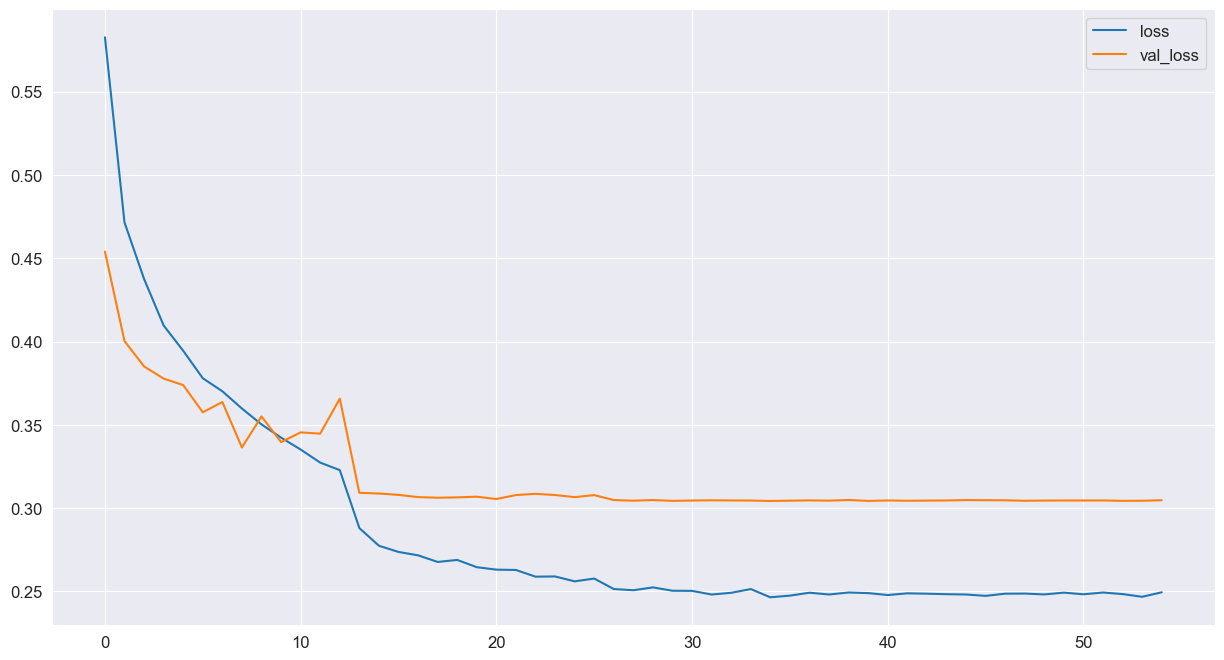

In [145]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(y=["loss", "val_loss"])
plt.show()

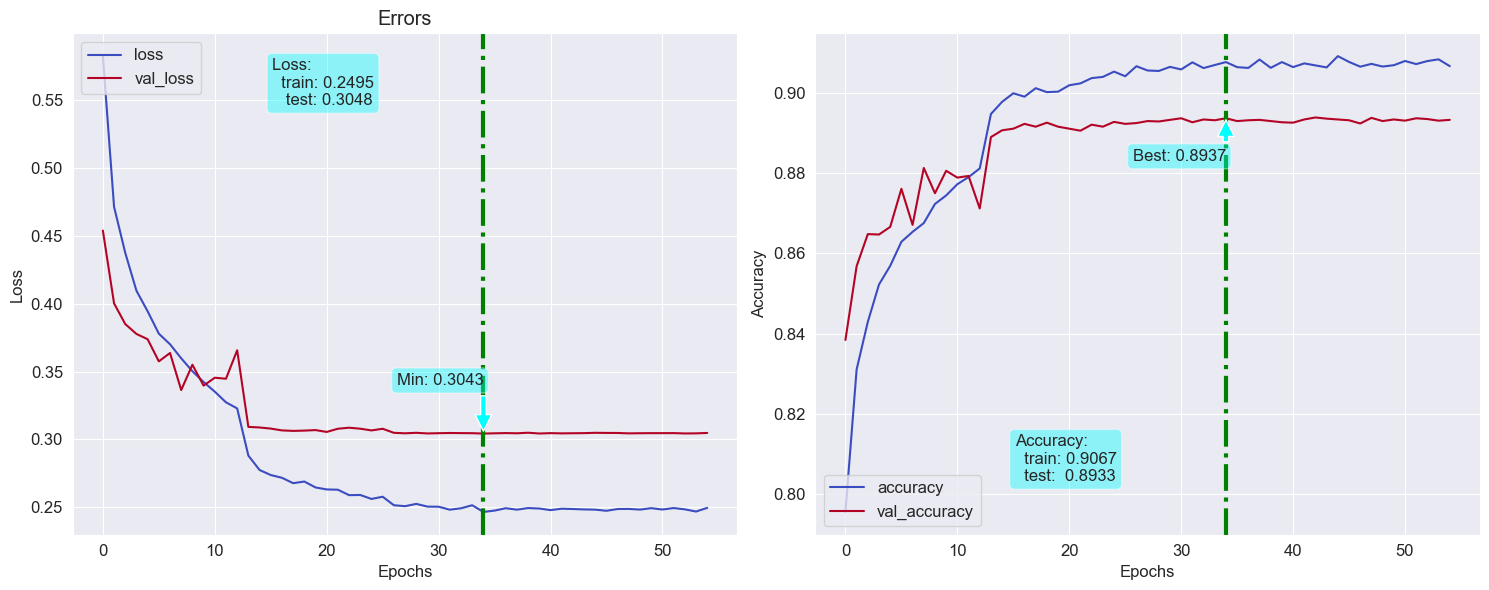

In [146]:
plt.show()
fn_plot_tf_hist(loss_df)